<a href="https://colab.research.google.com/github/StanleyLiangYork/DeepLearningForMalaria/blob/master/blood_cell_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script demonstrates the implementation of a basic GAN model to generate normal and malaria infected blood cells

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc4


Copy the blood cell images from the GCP storage

In [2]:
!gsutil cp gs://pet-detect-239118/malaria.zip ./malaria.zip

Copying gs://pet-detect-239118/malaria.zip...
| [1 files][ 60.5 MiB/ 60.5 MiB]                                                
Operation completed over 1 objects/60.5 MiB.                                     


Unzip the blood cell folder

In [0]:
from zipfile import ZipFile
import os

with ZipFile('malaria.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

list all blood cell images file (PNG) in a list and shuffle

In [4]:
import pathlib
import random

data_dir = './malaria' 
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.png')))
image_list = list(data_dir.glob('*/*.png'))
random.shuffle(image_list)
print('total amount of images in the training set: ', image_count)

total amount of images in the training set:  24820


split the file names and use the sub-folder name as label </p>
Randomly display 25 labeled images with

24820


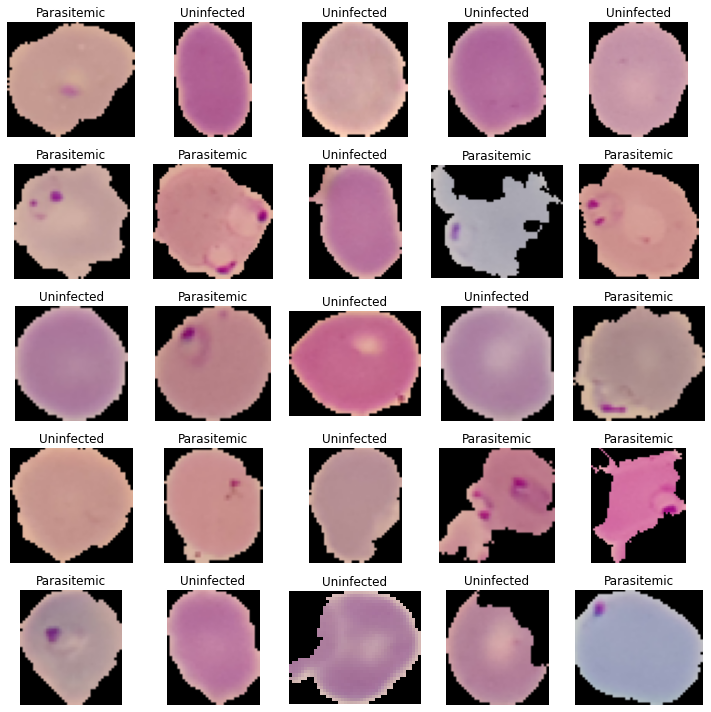

In [5]:
from matplotlib import pyplot as plt
from matplotlib.image import imread

labels = []
for filename in image_list:
  full_path = str(filename)
  label = full_path.split('/')[1]
  labels.append(label)

print(len(labels))

plt.figure(figsize=(10,10))
for i, filename in enumerate(image_list[:25]):
  plt.subplot(5,5, i+1)
  image = imread(filename)
  plt.title(labels[i])
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout()
plt.show()  

One hot encode the labels

In [6]:
from numpy import zeros

tags = ['Parasitemic', 'Uninfected']
row = len(labels)
encoding = zeros((row,2), dtype='uint8')
for i, label in enumerate(labels):
  if label == tags[0]:
    encoding[i][0] = 1
  else:
    encoding[i][1] = 1
print(encoding[0])
print(encoding[2])

[1 0]
[0 1]


Read and convert all images into a numpy array with labels </p>
Save the array as a numpy object

In [0]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
from numpy import savez_compressed


photos=[]
targets=[]

for i, filename in enumerate(image_list):
  photo = load_img(filename, target_size=(32,32))
  photo = img_to_array(photo, dtype='uint8')
  target = encoding[i]
  photos.append(photo)
  targets.append(target)


X = np.asarray(photos, dtype='uint8')
Y = np.asarray(targets, dtype='uint8')
savez_compressed('malaria_data.npz', X, Y)

In [8]:
print(X.shape)
print(Y.shape)

(24820, 32, 32, 3)
(24820, 2)


Define the discriminator model </p>
Unlike the classic CNN that use pooling layers to downsample the tensors, </p> we use convolutional layer with strike=2 to downsample the tensors

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         2

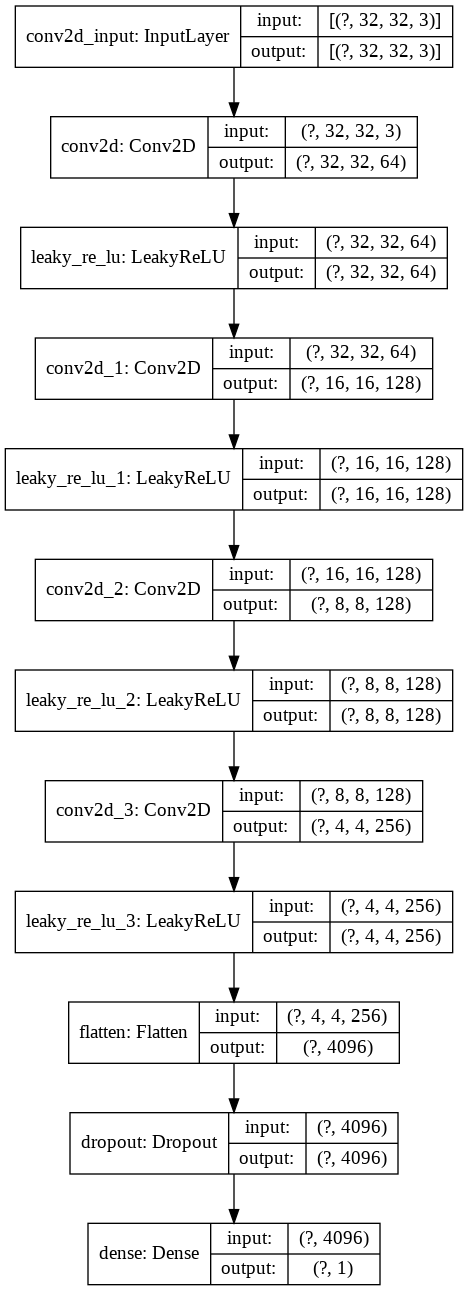

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.utils import plot_model

def define_discriminator(in_shape=(32,32,3)):
  model = Sequential()
  model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

model = define_discriminator()
model.summary()
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

Convert the image pixels from unsigned integer to float </p>
Rescale the value from [0,255] to [-1, 1]

The generate_real_samples() function will take the training dataset as an argument and will select a random subsample of images;
it will also return class labels for the sample, specifically a class label of 1, to indicate real images.</p>
The generate fake samples() generate images from random pixel values scale them to [-1,1], and assign a label of 0 to indicate fake image

In [0]:
# convert from unsigned ints to floats
X = X.astype('float32')
# scale from [0,255] to [-1,1]
X = (X - 127.5) / 127.5

Try to train the discriminator alone for 20 epochs

In [11]:
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from numpy import load
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU
import os.path

if not os.path.exists('malaria_data.npz'):
    !gsutil cp gs://pet-detect-239118/malaria_data.npz ./malaria_data.npz

# load image
def load_dataset():
   data = load('./malaria_data.npz')
   X, Y = data['arr_0'], data['arr_1']
   X = X.astype('float32')
   X = (X-127.5)/127.5
   return X, Y

# select read sample
def generate_real_samples(dataset, n_samples):
  idx = randint(0, dataset.shape[0], n_samples)
  X = dataset[idx]
  y = ones((n_samples, 1))
  return X, y

# generate n fake samples with class labels
def generate_fake_samples(n_samples):
  X = rand(32 * 32 * 3 * n_samples)
  X = -1 + X * 2
  X =  X.reshape((n_samples, 32, 32, 3))
  y = zeros((n_samples, 1))
  return X, y

# train the discriminator model
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
  half_batch = int(n_batch / 2)
  for i in range(n_iter):
    # get randomly selected 'real' samples
    X_real, y_real = generate_real_samples(dataset, half_batch)
    # update discriminator on real samples
    _, real_acc = model.train_on_batch(X_real, y_real)
    # get randomly selected 'fake' samples
    X_fake, y_fake = generate_fake_samples(half_batch)
    # update discriminator on fake samples6.2f
    _, fake_acc = model.train_on_batch(X_fake, y_fake)
    # summarize performance
    print("==== iterate:{:d}, real={:6.3f}%, fake={:6.3f}% ====".format(i+1, real_acc*100, fake_acc*100))

# load image dataset
dataset, _ =  load_dataset()
train_discriminator(model, dataset)  


==== iterate:1, real=53.125%, fake= 1.562% ====
==== iterate:2, real=100.000%, fake=10.938% ====
==== iterate:3, real=100.000%, fake=42.188% ====
==== iterate:4, real=100.000%, fake=93.750% ====
==== iterate:5, real=100.000%, fake=100.000% ====
==== iterate:6, real=100.000%, fake=100.000% ====
==== iterate:7, real=100.000%, fake=100.000% ====
==== iterate:8, real=98.438%, fake=100.000% ====
==== iterate:9, real=100.000%, fake=100.000% ====
==== iterate:10, real=100.000%, fake=100.000% ====
==== iterate:11, real=98.438%, fake=100.000% ====
==== iterate:12, real=98.438%, fake=100.000% ====
==== iterate:13, real=100.000%, fake=100.000% ====
==== iterate:14, real=100.000%, fake=100.000% ====
==== iterate:15, real=100.000%, fake=100.000% ====
==== iterate:16, real=98.438%, fake=100.000% ====
==== iterate:17, real=98.438%, fake=100.000% ====
==== iterate:18, real=100.000%, fake=100.000% ====
==== iterate:19, real=100.000%, fake=100.000% ====
==== iterate:20, real=100.000%, fake=100.000% ====

Define the Generator model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)      

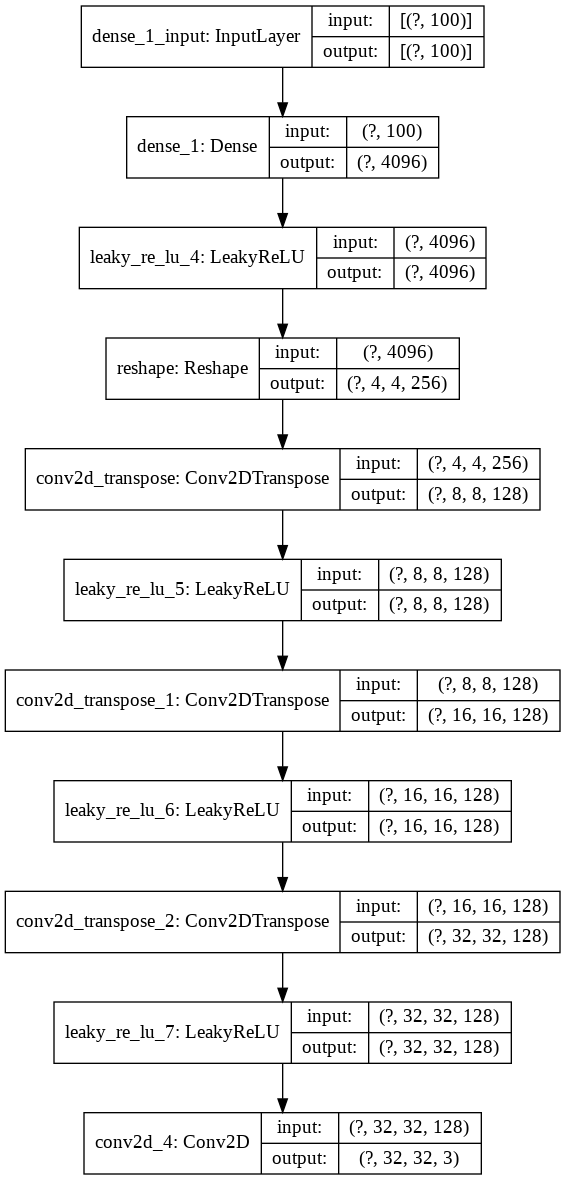

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.utils import plot_model

# define the standalone generator model
def define_generator(latent_dim):
  model = Sequential()
  # foundation for 4x4 image
  n_nodes = 256 * 4 * 4
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4, 4, 256)))
  # upsample to 8X8
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 16X16
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 32X32
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # output layer
  model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
  return model

# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

Generate the latent space as input

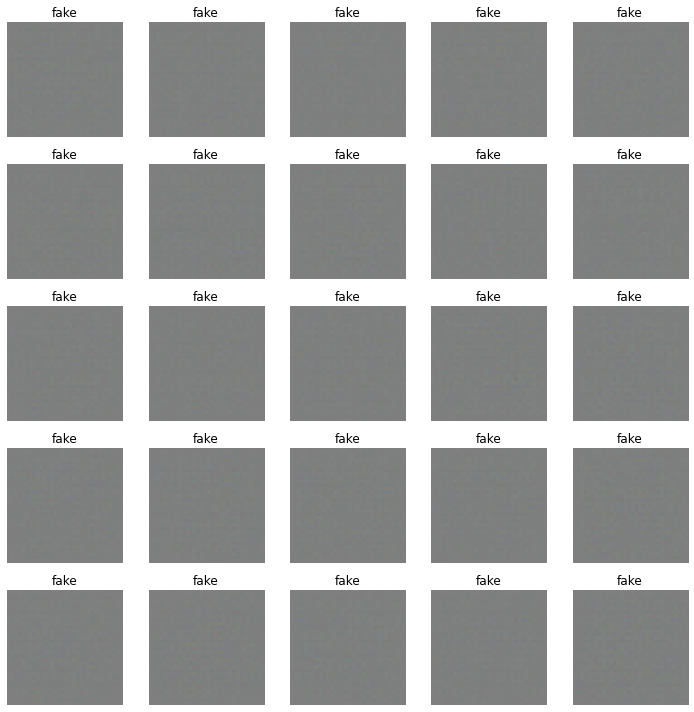

In [13]:
from numpy import zeros
from numpy.random import randn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from matplotlib import pyplot as plt

# define the standalone generator model
def define_generator(latent_dim):
  model = Sequential()
  # foundation for 4x4 image
  n_nodes = 256 * 4 * 4
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4, 4, 256)))
  # upsample to 8x8
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 16x16
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 32x32
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # output layer
  model.add(Conv2D(3,(3,3), activation='tanh', padding='same'))
  return model

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  X = g_model.predict(x_input)
  # create 'fake' class labels (0)
  y = zeros((n_samples, 1))
  return X, y

# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# scale pixel values from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the generated samples
plt.figure(figsize=(10,10))
for i in range(n_samples):
  plt.subplot(5,5,i+1)
  plt.imshow(X[i])
  plt.axis('off')
  plt.title('fake')

plt.tight_layout()
plt.show() 

Define the GAN model as the third logical model of combined the distriminator and the generator

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 32, 32, 3)         1466115   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 522497    
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


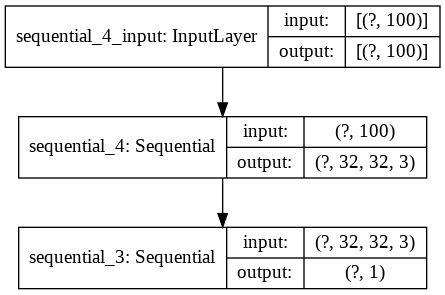

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
  # make weights in the logical discriminator not trainable
  d_model.trainable = False
  # connect them
  model = Sequential()
  # add the generator
  model.add(g_model)
  # add the discriminator
  model.add(d_model)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)



In [0]:
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from numpy.random import randn
from numpy import load
from matplotlib import pyplot as plt
import os.path

if not os.path.exists('malaria_data.npz'):
    !gsutil cp gs://pet-detect-239118/malaria_data.npz ./malaria_data.npz

# load the real images
def load_real_samples():
   data = load('./malaria_data.npz')
   X, Y = data['arr_0'], data['arr_1']
   X = X.astype('float32')
   X = (X-127.5)/127.5
   return X, Y

In [16]:
import numpy as np
dataset, labels = load_real_samples()
labels[0]
tags = ['Parasitemic', 'Uninfected']
tag = np.array([1,1])
print(tag==labels[0])
result = tag==labels[0]
if result[0]==True:
  print('Parasitemic')

[ True False]
Parasitemic


Full implementation of the GAN model training

In [18]:
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from numpy.random import randn
from numpy import load
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU
from matplotlib import pyplot as plt
import os.path
from os import mkdir

if not os.path.exists('malaria_data.npz'):
    !gsutil cp gs://pet-detect-239118/malaria_data.npz ./malaria_data.npz

# make the output folder
mkdir('/content/output')

# load the real images
def load_real_samples():
   data = load('./malaria_data.npz')
   X, Y = data['arr_0'], data['arr_1']
   X = X.astype('float32')
   X = (X-127.5)/127.5
   return X, Y

# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
  model = Sequential()
  model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(64, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten())
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

# define the standalone generator model
def define_generator(latent_dim):
  model = Sequential()
  # foundation for 4x4 image
  n_nodes = 256 * 4 * 4
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4, 4, 256)))
  # upsample to 8x8
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 16x16
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 32x32
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # output layer
  model.add(Conv2D(3,(3,3), activation='tanh', padding='same'))
  return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
  # make weights in the logical discriminator not trainable
  d_model.trainable = False
  # connect them
  model = Sequential()
  # add the generator
  model.add(g_model)
  # add the discriminator
  model.add(d_model)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

# select real samples
def generate_real_samples(dataset, n_samples):
  idx = randint(0, dataset.shape[0], n_samples)
  X = dataset[idx]
  y = ones((n_samples, 1))
  return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  X = g_model.predict(x_input)
  # create 'fake' class labels (0)
  y = zeros((n_samples, 1))
  return X, y

# create and save a plot of generated images
def save_plot(examples, epoch, n=5):
  # scale from [-1,1] to [0,1]
  examples = (examples + 1) / 2.0
  # plot images
  plt.figure(figsize=(10,10))
  for i in range(n*n):
    plt.subplot(n,n,1+i)
    plt.axis('off')
    plt.imshow(examples[i])
  # save plot to file
  filename = "/content/output/generated_plot_e{:d}.png".format(epoch+1)
  plt.savefig(filename)
  plt.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=1000):
  # prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(X_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print("==== Accuracy real={:6.3f}%, fake={:6.3f}% ====".format(acc_real*100, acc_fake*100))
  # save plot
  save_plot(X_fake, epoch)
  # save the generator model tile file
  filename = "/content/output/generator_model_e{:d}.h5".format(epoch+1)
  g_model.save(filename)


# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=400, n_batch=1024):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # enumerate the epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # update discriminator model weights
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)
      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator model weights
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      print("==epoch:{:d}, {:d}/{:d}, d_true_loss={:.3f},d_fake_loss={:.3f},g_loss={:.3f}".format(i+1,j+1,bat_per_epo, d_loss1, d_loss2, g_loss))
      # evaluate the model performance every 20 epochs
    if (i+1)%20 == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset, _ = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
==epoch:193, 5/24, d_true_loss=0.007,d_fake_loss=0.000,g_loss=8.862
==epoch:193, 6/24, d_true_loss=0.000,d_fake_loss=0.001,g_loss=9.108
==epoch:193, 7/24, d_true_loss=0.001,d_fake_loss=0.001,g_loss=9.167
==epoch:193, 8/24, d_true_loss=0.000,d_fake_loss=0.001,g_loss=9.485
==epoch:193, 9/24, d_true_loss=0.008,d_fake_loss=0.001,g_loss=8.090
==epoch:193, 10/24, d_true_loss=0.009,d_fake_loss=0.006,g_loss=9.137
==epoch:193, 11/24, d_true_loss=0.000,d_fake_loss=0.000,g_loss=10.722
==epoch:193, 12/24, d_true_loss=0.009,d_fake_loss=0.000,g_loss=10.121
==epoch:193, 13/24, d_true_loss=0.007,d_fake_loss=0.001,g_loss=8.637
==epoch:193, 14/24, d_true_loss=0.000,d_fake_loss=0.001,g_loss=8.678
==epoch:193, 15/24, d_true_loss=0.002,d_fake_loss=0.001,g_loss=8.457
==epoch:193, 16/24, d_true_loss=0.000,d_fake_loss=0.001,g_loss=9.214
==epoch:193, 17/24, d_true_loss=0.004,d_fake_loss=0.001,g_loss=8.764
==epoch:193, 18/24, d_true_loss=0.004,d_fake_loss=0.002

In [0]:
from zipfile import ZipFile
import os

zf = ZipFile("output.zip", "w")
for dirname, subdirs, files in os.walk("output"):
    zf.write(dirname)
    for filename in files:
        zf.write(os.path.join(dirname, filename))
zf.close()

loading the generator model and generating images

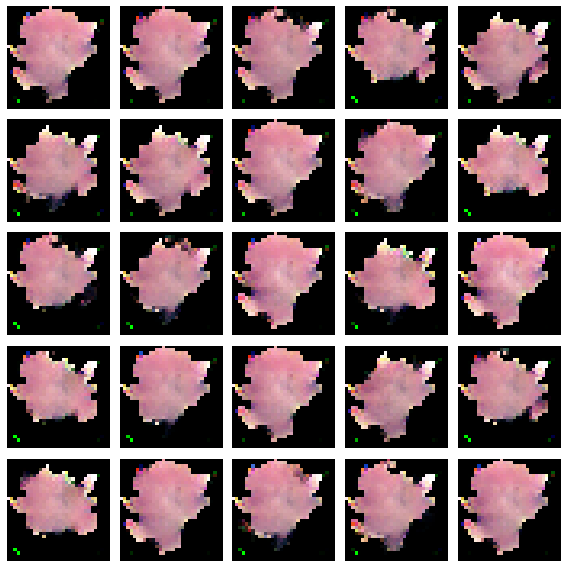

In [20]:
from tensorflow.keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot as plt
from zipfile import ZipFile
import os

if not os.path.exists('output.zip'):
    !gsutil cp gs://pet-detect-239118/sixth.zip ./output.zip

if not os.path.exists('malaria_data.npz'):
    !gsutil cp gs://pet-detect-239118/malaria_data.npz ./malaria_data.npz

if not os.path.exists('output.zip'):
  with ZipFile('output.zip', 'r') as zipObj:
    # Extract all the contents of zip file in the output folder
    zipObj.extractall()

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  x_input = randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

def save_plot(examples, n):
  plt.figure(figsize=(8,8))
  for i in range(n * n):
    plt.subplot(n,n, 1+i)
    plt.axis('off')
    plt.imshow(examples[i,:,:])
  plt.tight_layout()
  plt.show()

model = load_model('/content/output/generator_model_e240.h5')
model.compile(loss='binary_crossentropy', optimizer='Adam')

latent_points = generate_latent_points(100, 25)
X = model.predict(latent_points)
X = (X + 1) / 2.0
save_plot(X, 5)

generating an image for a specific point in the latent space

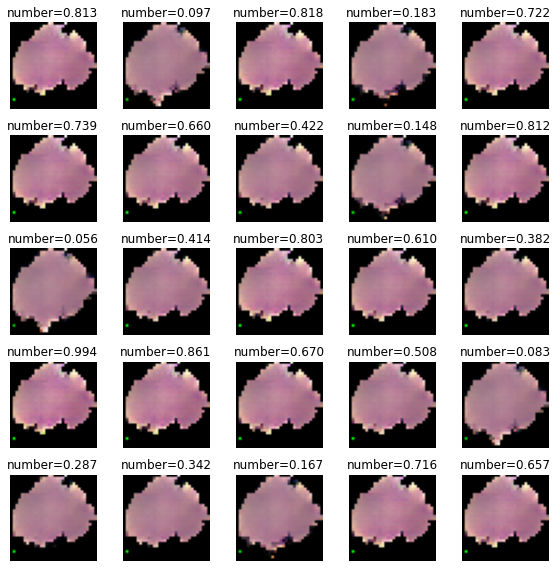

In [22]:
from tensorflow.keras.models import load_model
from numpy import asarray
from matplotlib import pyplot as plt
from numpy.random import rand


model = load_model('/content/output/generator_model_e280.h5')
plt.figure(figsize=(8,8))

for i in range(25):
  plt.subplot(5,5, 1+i)
  num = float(rand(1))
  vector = asarray([[num for _ in range(100)]])
  # generate image
  X = model.predict(vector)
  text = "number={:4.3f}".format(num)
  # scale from [-1,1] to [0,1]
  X = (X + 1) / 2.0
  plt.imshow(X[0,:,:,:])
  plt.title(text)
  plt.axis('off')

plt.tight_layout()
plt.show()